# rapidity fits

In [1]:
import sys,os
os.chdir('../')
import itertools as it
import numpy as np
import pandas as pd
from scipy.special import beta
from scipy.integrate import quad
import pylab as py
from  matplotlib import rc
from  matplotlib import rc
from matplotlib.colors import LogNorm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
import matplotlib
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
from matplotlib.colors import LogNorm
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tools.tools import save,load,lprint,load_config
from tools.bar import BAR
from fitlab.resman import RESMAN
import fitlab.nest

## load core libs and compute residuals

In [2]:
conf=load_config('inputs/upol.py')
resman=RESMAN(conf)
parman=resman.conf['parman']
res=resman.get_residuals(parman.par)

loading sidis data sets 1005

## load rapidity fits

In [3]:
PAR=load('maxlike/rap_fits.dat')
PAR

{1.5: array([ 0.56289338,  0.58057805,  0.14028143,  0.11930116]),
 2.0: array([ 0.52840254,  0.49365696,  0.14856939,  0.12488323]),
 2.5: array([ 0.43923215,  0.41271125,  0.1517873 ,  0.1474689 ]),
 3.0: array([ 0.33993636,  0.25285457,  0.15302982,  0.16912197]),
 3.5: array([ 0.2670366 ,  0.3766198 ,  0.15594102,  0.19038116])}

## Kinematics

In [4]:
tabs=resman.sidisres.tabs
data=pd.concat([pd.DataFrame(tabs[k]) for k in tabs])
data['yp-yh']=data['yp']-data['yh']

In [5]:
data.columns

Index([      u'Ebeam',          u'F2',           u'N',          u'Q2',
             u'Shift',          u'W2',       u'alpha',         u'col',
                u'dy',      u'hadron',           u'i',         u'obs',
                u'pT', u'r-residuals',   u'residuals',       u'shift',
            u'stat_u',   u'systabs_u',     u'systole',     u'systrel',
            u'target',         u'thy',       u'value',           u'x',
                 u'y',          u'yh',          u'yp',           u'z',
             u'yp-yh'],
      dtype='object')

In [16]:
def _plot_kin(ax,d,d_current,tag,label):
    ax.hist(d[tag],bins=50,label=r'$\rm full$');
    ax.set_xlabel(label,size=20)
    ax.hist(d_current[tag],bins=50,label=r'$y_p-y_h>3$');
    ax.tick_params(axis='both', which='major', labelsize=20)

def plot_kin(data,target,hadron):
    d=data.query("target=='%s'"%target).query("hadron=='%s'"%hadron)
    d_current=d.query('yp-yh>3')
    nrows,ncols=3,3
    py.figure(figsize=(ncols*5,nrows*3))
    tags={}
    tags['W2']=r'$W^2$'
    tags['pT']=r'$p_T$'
    tags['Q2']=r'$Q^2$'
    tags['z']=r'$z$'
    tags['yp-yh']=r'$y_p-y_h$'
    cnt=1
    for tag in tags:
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        _plot_kin(ax,d,d_current,tag,tags[tag])
        if cnt==2: ax.legend(fontsize=20,bbox_to_anchor=(-0.5, 0.5))


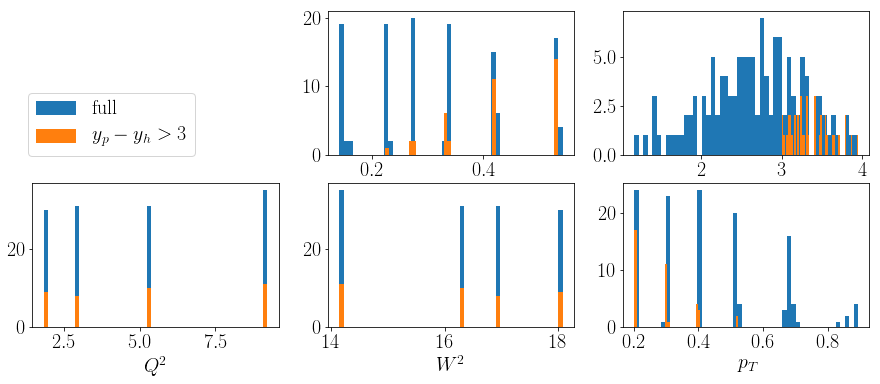

In [17]:
plot_kin(data,'proton','pi+')

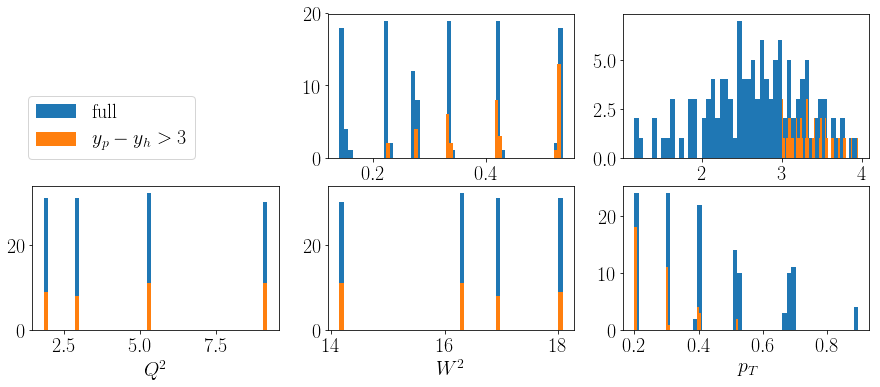

In [18]:
plot_kin(data,'proton','pi-')

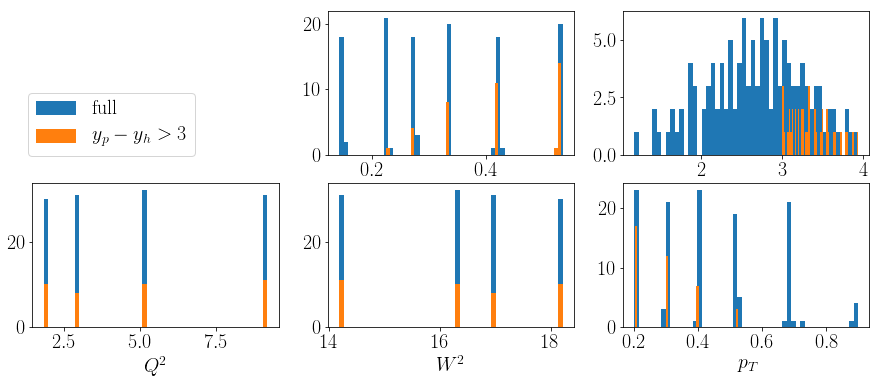

In [20]:
plot_kin(data,'deuteron','pi+')

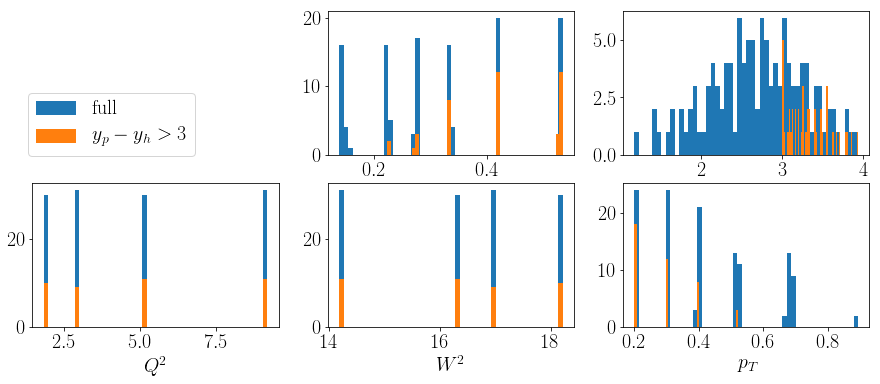

In [19]:
plot_kin(data,'deuteron','pi-')

## Data and theory in $y_h$ space

In [37]:
p0=np.copy(conf['parman'].par)    
def get_sample(pTmin,pTmax,W2min,W2max,target,hadron):
    d=data.query("target=='%s'"%target).query("hadron=='%s'"%hadron)
    d=d.query('W2>%f and W2<%f'%(W2min,W2max))
    d=d.query('pT>%f and pT<%f'%(pTmin,pTmax))

    FUU=lambda x,z,Q2,pT: conf['sidis stfuncs'].get_FX(1,x,z,Q2,pT,'p',hadron)
    pT=d['pT']
    M=conf['aux'].M
    M2=conf['aux'].M**2
    Mh=conf['aux'].Mpi
    MhT=np.sqrt(Mh**2+pT**2)

    E=27.6
    x=d['x']
    z=d['z']
    Q2=d['Q2']
    y=Q2/(2*M*E*x)
    norm=1/x/y/Q2*(1-y+0.5*y**2)
    dy=d['yp']-d['yh']

    xn=2*x/(1+np.sqrt(1+4*x**2*M2/Q2))
    W2=d['W2']
    J=Q2*MhT*M*2*np.sinh(dy)/(W2+Q2)**3
    mult=d['value']
    alpha=d['alpha']
    F2=np.array([conf['dis stfuncs'].get_F2(x.values[i],Q2.values[i],'proton') for i in range(x.size)])
    xsec1=norm*mult*F2*J 
    dxsec1=norm*alpha*F2*J
    
    conf['parman'].set_new_params(p0)
    FUU2=np.array([FUU(x.values[i],z.values[i],Q2.values[i],pT.values[i]) for i in range(x.size)])
    xsec2=norm*FUU2*J * 2*np.pi*pT

    conf['parman'].set_new_params(PAR[3.0])
    FUU3=np.array([FUU(x.values[i],z.values[i],Q2.values[i],pT.values[i]) for i in range(x.size)])
    xsec3=norm*FUU3*J * 2*np.pi*pT
    
    return dy,xsec1,dxsec1,xsec2,xsec3


def plot_DOT(target,hadron):
    nrows,ncols=6,6
    py.figure(figsize=(ncols*3,nrows*3))

    W2=[[14,15],[16,16.5],[16.5,17],[18,18.5]]
    pT=[[0.15,0.25],[0.25,0.35],[0.35,0.45],[0.5,0.55],[0.65,0.75],[0.85,1]]
    cnt=0
    for ii in range(len(W2)):
        for jj in range(len(pT)):
            cnt+=1
            dy,xsec1,dxsec1,xsec2,xsec3=get_sample(pT[jj][0],pT[jj][1],W2[ii][0],W2[ii][1],target,hadron)
            if len(dy)==0: continue
            ax=py.subplot(nrows,ncols,cnt)
            ax.errorbar(dy,xsec1,yerr=dxsec1,fmt='k.')
            if len(dy)>1:
                ax.plot(dy,xsec2,'-')
                ax.plot(dy,xsec3,'--')
            else:
                ax.plot(dy,xsec2,'x')
                ax.plot(dy,xsec3,'+')
            ax.semilogy()
            ax.set_xlim(0,5)
            if any([cnt==kk for kk in [1,7,13,19,25]]): 
                ax.set_ylabel(r'$W^2=[%0.1f,%0.1f]$'%(W2[ii][0],W2[ii][1]),size=20)
            if any([cnt==kk for kk in [1,2,3,4,5,6]]):
                ax.set_title(r'$p_T=[%0.1f,%0.1f]$'%(pT[jj][0],pT[jj][1]),size=20)
            #ax.set_ylim(1e-4,1e-2)
            #ax.tick_params(axis='both', which='major', labelsize=20)
    py.tight_layout()

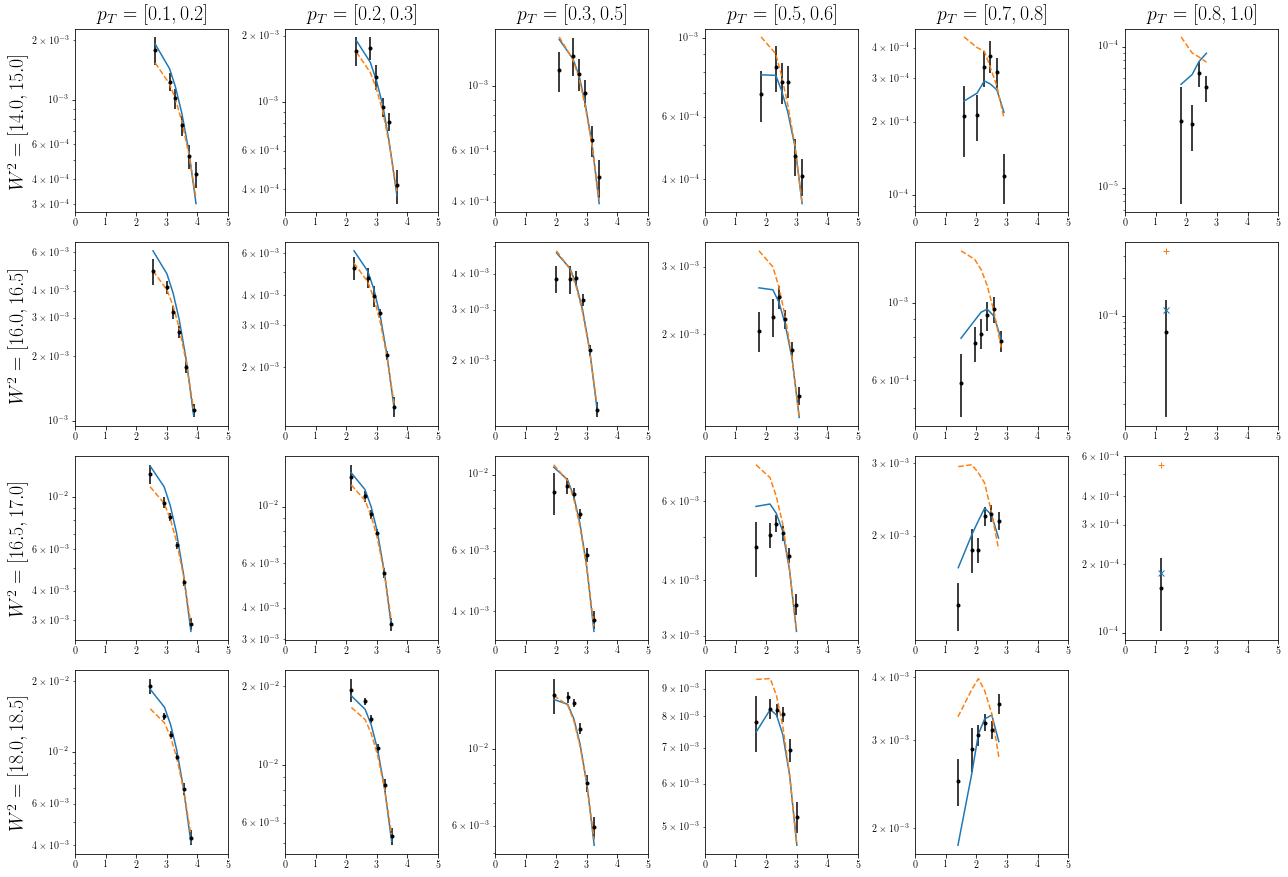

In [38]:
plot_DOT('proton','pi+')

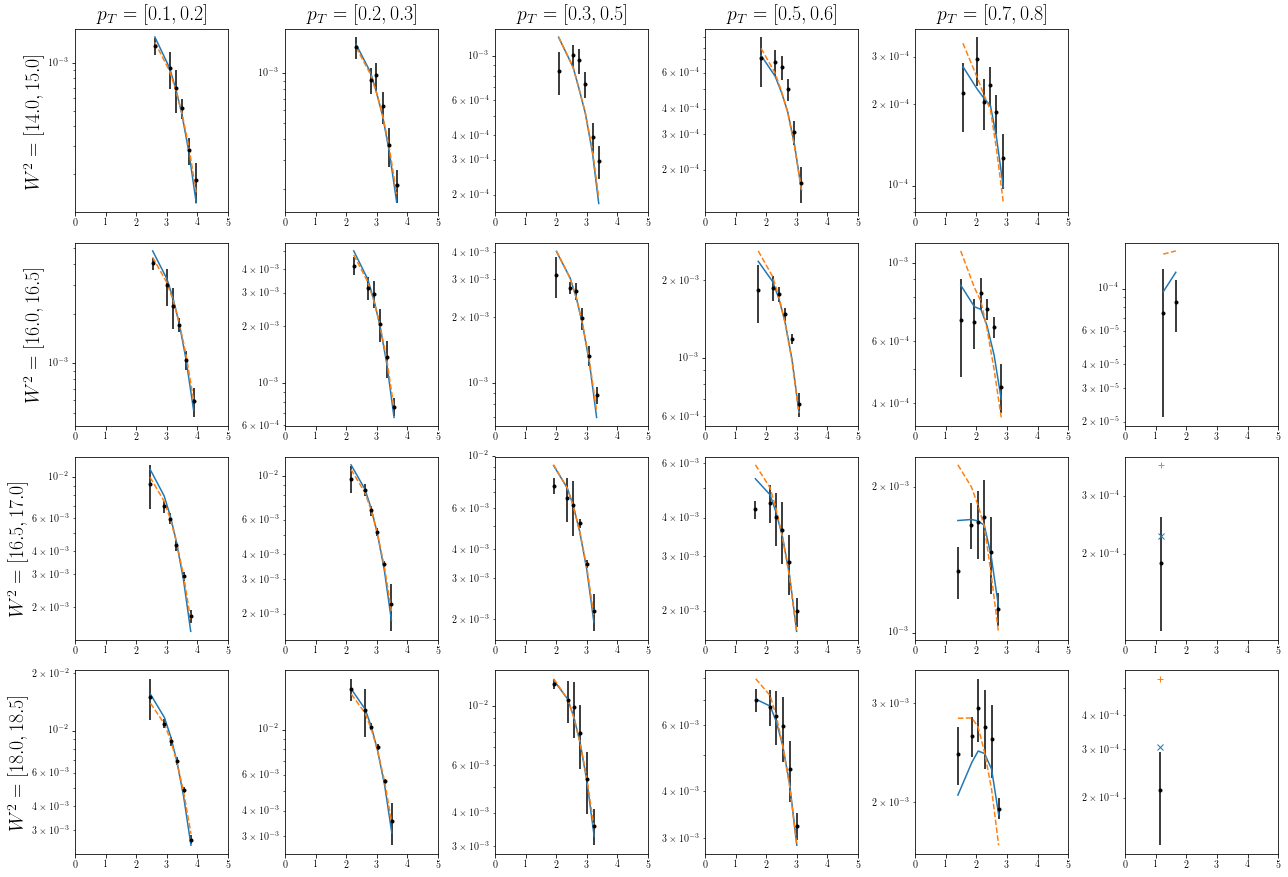

In [39]:
plot_DOT('proton','pi-')

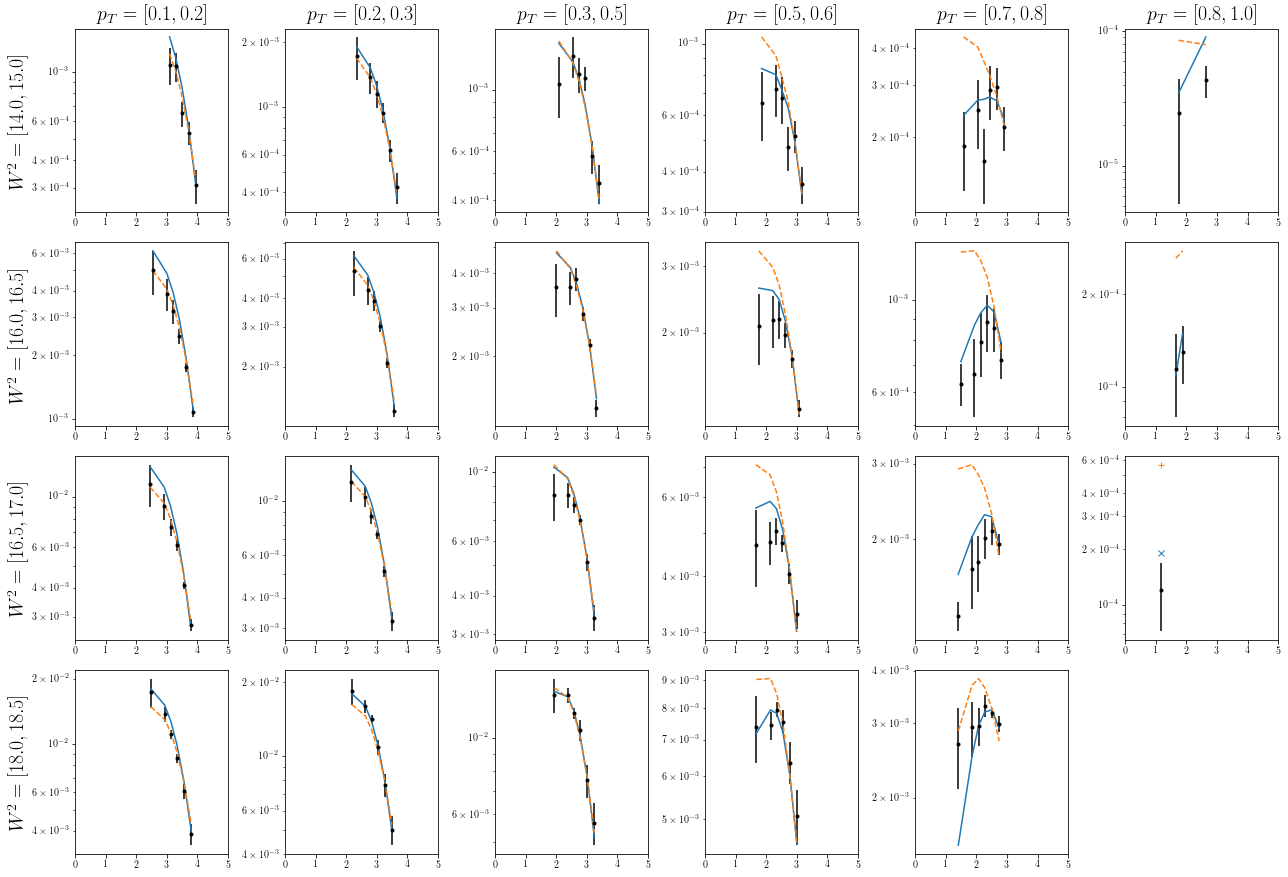

In [40]:
plot_DOT('deuteron','pi+')

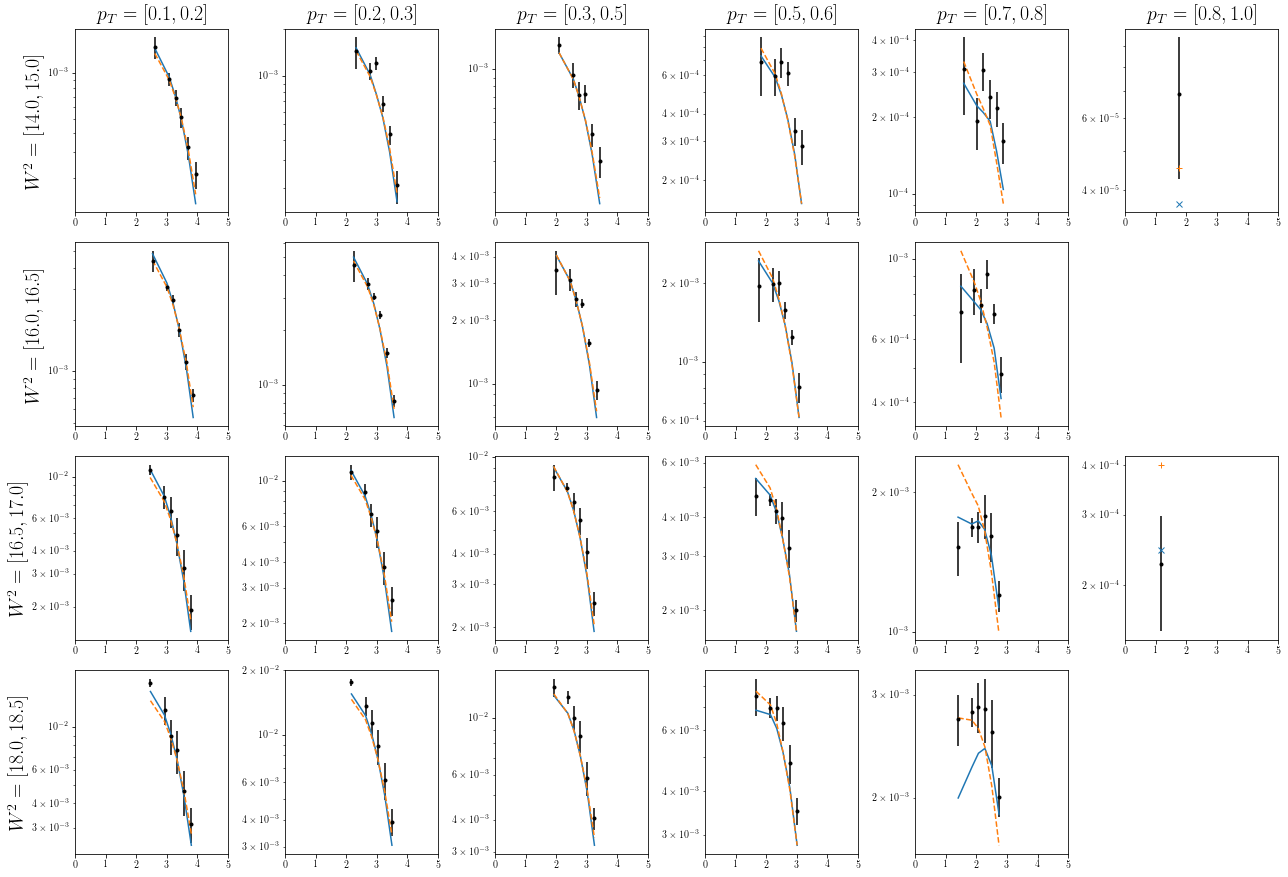

In [41]:
plot_DOT('deuteron','pi-')

## Junk

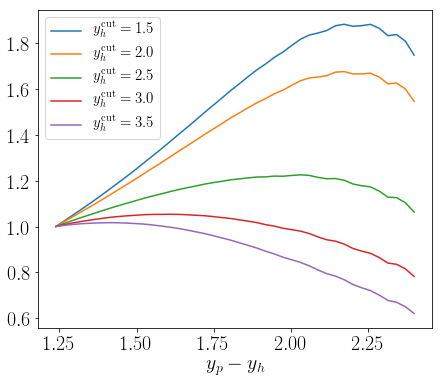

In [9]:
def get_xsec(par,dy,W2,Q2,pT):
    
    conf['parman'].set_new_params(par)
    
    FUU=lambda x,z,Q2,pT: conf['sidis stfuncs'].get_FX(1,x,z,Q2,pT,'p','pi+')
    
    
    M=conf['aux'].M
    M2=conf['aux'].M**2
    Mh=conf['aux'].Mpi
    MhT=np.sqrt(Mh**2+pT**2)
    x=Q2/(W2+Q2-M2)

    E=27.6
    y=Q2/(2*M*E*x)
    
    norm=1/x/y/Q2*(1-y+0.5*y**2)

    
    xn=2*x/(1+np.sqrt(1+4*x**2*M2/Q2))

    p0=3
    p1=p0
    p2=10
    
    
    z0=xn*MhT*M/(Q2-xn**2*M2)*(np.exp(p0)+np.exp(-p0))
    FUU0 = FUU(x,z0,Q2,pT)*np.sinh(p0)
    J0=Q2*MhT*M*2*np.sinh(p0)/(W2+Q2)**3
    
    z=xn*MhT*M/(Q2-xn**2*M2)*(np.exp(dy)+np.exp(-dy))
    R=(1+np.tanh(p2*(dy-p1)))/2
    W2=M2+Q2*(1-x)/x
    J=Q2*MhT*M*2*np.sinh(dy)/(W2+Q2)**3
    xsec=norm*FUU(x,z,Q2,pT)*J #* R + (1-R)*(FUU0*J0)

    #if x<1e-3 or x>0.6: xsec=0
    #if z<0.0001 or z>0.6: xsec=0
    if z<0.2 or z>0.6: xsec=0

    return xsec
    


tabs=resman.sidisres.tabs
yp,yh,dy=[],[],[]
for k in tabs: yh.extend(tabs[k]['yh'])
for k in tabs: dy.extend(tabs[k]['dy'])
for k in tabs: yp.extend(tabs[k]['yp'])

nrows,ncols=2,2
py.figure(figsize=(ncols*6,nrows*5))


ax=py.subplot(nrows,ncols,1)
W2=10
Q2=5
pT=0.8
dy=np.linspace(np.amin(dy),np.amax(dy),100)
for k in sorted(PAR):
    xsec=[get_xsec(PAR[k],_dy,W2,Q2,pT) for _dy in dy]
    I=[i for i in range(len(xsec)) if xsec[i]>0]
    xsec=np.array([xsec[i] for i in I])
    xsec_max=1#np.amax(xsec)
    dy=[dy[i] for i in I]
    ax.plot(dy,xsec/xsec[0],label=r'$y_h^{\rm cut}=%0.1f$'%k)
ax.legend(fontsize=15)
ax.set_xlabel(r'$y_p-y_h$',size=20)
ax.tick_params(axis='both', which='major', labelsize=20)
#ax.set_ylim(0,0.005)

py.tight_layout()

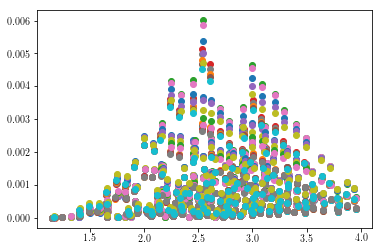

In [24]:
def plot(ax,par):
    tabs=resman.sidisres.tabs
    conf['parman'].set_new_params(par)
    
    for k in tabs:
        yp=tabs[k]['yp']
        yh=tabs[k]['yh']
        x=tabs[k]['x']
        z=tabs[k]['z']
        Q2=tabs[k]['Q2']
        pT=tabs[k]['pT']
        hadron=tabs[k]['hadron'][0]
        target=tabs[k]['target'][0]

        if target=='proton':
            FUU = np.array([conf['sidis stfuncs'].get_FX(1,x[i],z[i],Q2[i],pT[i],'p',hadron) for i in range(x.size)])
        if target=='deuteron':
            FUU = np.array([conf['sidis stfuncs'].get_FX(1,x[i],z[i],Q2[i],pT[i],'p',hadron) for i in range(x.size)])+\
                  np.array([conf['sidis stfuncs'].get_FX(1,x[i],z[i],Q2[i],pT[i],'n',hadron) for i in range(x.size)])
  
        dy=yp-yh    
        M=conf['aux'].M
        M2=conf['aux'].M**2
        Mh=conf['aux'].Mpi
        MhT=np.sqrt(Mh**2+pT**2)
        W2=M2+Q2*(1-x)/x
        J=Q2*MhT*M*2*np.sinh(dy)/(W2+Q2)**3
        ax.plot(dy,FUU*J,'o')

ax=py.subplot(111)
dy=np.linspace(0,5,100)
for k in sorted(PAR): plot(ax,PAR[k])
#ax.set_ylim(0,0.003)


In [ ]:
def plot(ax,par):
    tabs=resman.sidisres.tabs
    conf['parman'].set_new_params(par)
    
    for k in tabs:
        yp=tabs[k]['yp']
        yh=tabs[k]['yh']
        x=tabs[k]['x']
        z=tabs[k]['z']
        Q2=tabs[k]['Q2']
        pT=tabs[k]['pT']
        hadron=tabs[k]['hadron'][0]
        target=tabs[k]['target'][0]

        if target=='proton':
            FUU = np.array([conf['sidis stfuncs'].get_FX(1,x[i],z[i],Q2[i],pT[i],'p',hadron) for i in range(x.size)])
        if target=='deuteron':
            FUU = np.array([conf['sidis stfuncs'].get_FX(1,x[i],z[i],Q2[i],pT[i],'p',hadron) for i in range(x.size)])+\
                  np.array([conf['sidis stfuncs'].get_FX(1,x[i],z[i],Q2[i],pT[i],'n',hadron) for i in range(x.size)])
  
        dy=yp-yh    
        M=conf['aux'].M
        M2=conf['aux'].M**2
        Mh=conf['aux'].Mpi
        MhT=np.sqrt(Mh**2+pT**2)
        W2=M2+Q2*(1-x)/x
        J=Q2*MhT*M*2*np.sinh(dy)/(W2+Q2)**3
        ax.plot(dy,FUU*J,'o')

ax=py.subplot(111)
dy=np.linspace(0,5,100)
for k in sorted(PAR): plot(ax,PAR[k])
#ax.set_ylim(0,0.003)
